<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-bookcamp/6-ensemble-learning/02_credit_risk_scoring_using_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Credit risk scoring project: Decision tree

Imagine that we work at a bank. When we receive a loan application, we need to make
sure that if we give the money, the customer will be able to pay it back. Every application
carries a risk of default — the failure to return the money.

Credit risk scoring is a binary classification problem: the target is positive (“1”) if the
customer defaults and negative (“0”) otherwise.

We will use machine learning to calculate the risk of
default. The plan for the project is the following:

* We will train decision tree model for predicting the probability
of default.
* Then we combine multiple decision trees into one model — a random forest.
* Finally, we explore a different way of combining decision trees — gradient
boosting(XGBoost).

##Setup

In [ ]:
import pandas as pd
import numpy as np
import pickle 
import requests

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, export_text
from graphviz import Source

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!wget https://github.com/rahiakela/machine-learning-research-and-practice/raw/main/machine-learning-bookcamp/6-ensemble-learning/credit_scoring.csv

##Dataset

In [ ]:
# let’s read our dataset
data_df = pd.read_csv("credit_scoring.csv")
print(len(data_df))
data_df.head()

4455


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


##Data cleaning

In [ ]:
# let’s lowercase all the column names
data_df.columns = data_df.columns.str.lower()
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [ ]:
# Let’s handle the categorical column
data_df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

In [ ]:
status_values = {
  1: "ok", 
  2: "default", 
  0: "unk"
}
data_df.status = data_df.status.map(status_values)
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [ ]:
data_df.home.value_counts()

2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: home, dtype: int64

In [ ]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
data_df.home = data_df.home.map(home_values)

In [ ]:
data_df.marital.value_counts()

2    3241
1     978
4     130
3      67
5      38
0       1
Name: marital, dtype: int64

In [ ]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
data_df.marital = data_df.marital.map(marital_values)

In [ ]:
data_df.records.value_counts()

1    3682
2     773
Name: records, dtype: int64

In [ ]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
data_df.records = data_df.records.map(records_values)

In [ ]:
data_df.job.value_counts()

1    2806
3    1024
2     452
4     171
0       2
Name: job, dtype: int64

In [ ]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
data_df.job = data_df.job.map(job_values)

In [ ]:
data_df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [ ]:
# let’s check the summary statistics for each of the columns
data_df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [ ]:
# Let’s replace this big number with NaN for these columns
for c in ["income", "assets", "debt"]:
  data_df[c] = data_df[c].replace(to_replace=99999999, value=np.nan) 

In [ ]:
data_df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

In [ ]:
data_df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [ ]:
# let’s look at our target variable status
data_df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [ ]:
# this row is not useful, so let’s remove it
data_df = data_df[data_df.status != "unk"]

In [ ]:
data_df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

##Dataset preparation

In [ ]:
# Let’s start by splitting the data
df_train_full, df_test = train_test_split(data_df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [ ]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [ ]:
# let's convert label to 0 and 1
y_train = (df_train.status == "default").values
y_val = (df_val.status == "default").values

In [ ]:
# Now we need to remove status from the DataFrames.
del df_train["status"]
del df_val["status"]

In [ ]:
# let's replace the missing values with zero
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [ ]:
# let's convert the DataFrames into dictionaries
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

In [ ]:
dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [ ]:
# now, let's apply one-hot encoding technique
dv = DictVectorizer(sparse=False)

x_train = dv.fit_transform(dict_train)
x_val = dv.transform(dict_val)

##Decision trees

In [ ]:
# Let's fit the tree with default parameters
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
# To get the predictions (probabilities)
y_pred = dt.predict_proba(x_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [ ]:
# And on validation
y_pred = dt.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6519641084013466

That's a case of overfitting - our model on the training data performs perfectly, but fails on validation.

In [ ]:
# Let's change the depth parameter: restring the size of the tree to 2 levels
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [ ]:
y_pred = dt.predict_proba(x_train)[:, 1]
acc = roc_auc_score(y_train, y_pred)
print(f"train accuracy: {acc}")

y_pred = dt.predict_proba(x_val)[:, 1]
acc = roc_auc_score(y_val, y_pred)
print(f"val accuracy: {acc}")

train accuracy: 0.7054989859726213
val accuracy: 0.6685264343319367


In [ ]:
# let's show the tree
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


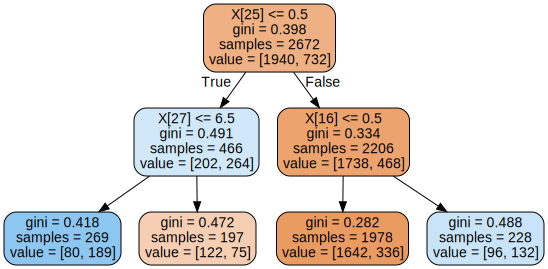

In [ ]:
# let's plot the tree
export_graphviz(dt,
                out_file="dt1.dot",
                rounded=True,
                filled=True)
Source.from_file("dt1.dot")

##Parameter tuning

In [ ]:
# Let’s find the best parameters for max_depth
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(x_train, y_train)
  y_pred = dt.predict_proba(x_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)
  print(f"{depth} -> {auc:.3f}")

1 -> 0.606
2 -> 0.669
3 -> 0.739
4 -> 0.761
5 -> 0.767
6 -> 0.761
10 -> 0.704
15 -> 0.668
20 -> 0.665
None -> 0.660


In [ ]:
for depth in [1, 5, 10, 15, 20, 50, 100, 200]:
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(x_train, y_train)
  y_pred = dt.predict_proba(x_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)
  print(f"{depth} -> {auc:.3f}")

1 -> 0.606
5 -> 0.767
10 -> 0.692
15 -> 0.660
20 -> 0.657
50 -> 0.668
100 -> 0.657
200 -> 0.666


In [ ]:
# Let’s find the best parameters for min_leaf_size
for m in [4, 5, 6]:
  print(f"depth: {m}")
  for leaf_size in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=leaf_size)
    dt.fit(x_train, y_train)
    y_pred = dt.predict_proba(x_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"{m} -> {auc:.3f}")
  print()

depth: 4
4 -> 0.761
4 -> 0.761
4 -> 0.761
4 -> 0.764
4 -> 0.761
4 -> 0.753
4 -> 0.756
4 -> 0.747

depth: 5
5 -> 0.766
5 -> 0.768
5 -> 0.762
5 -> 0.773
5 -> 0.774
5 -> 0.767
5 -> 0.763
5 -> 0.759

depth: 6
6 -> 0.762
6 -> 0.763
6 -> 0.778
6 -> 0.785
6 -> 0.774
6 -> 0.770
6 -> 0.776
6 -> 0.768



In [ ]:
for leaf_size in [1, 5, 10, 15, 20, 50, 100, 200]:
  dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=leaf_size)
  dt.fit(x_train, y_train)
  y_pred = dt.predict_proba(x_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)
  print(f"{leaf_size} -> {auc:.3f}")

1 -> 0.745
5 -> 0.762
10 -> 0.778
15 -> 0.786
20 -> 0.774
50 -> 0.770
100 -> 0.776
200 -> 0.768


In [ ]:
# We have found the best parameters, so let’s use them to train the final model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(x_train, y_train)

y_pred = dt.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"{auc:.3f}")

0.785


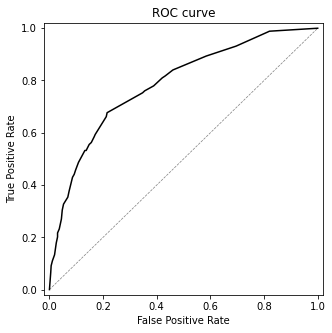

In [ ]:
# let's plot roc curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

Decision trees are simple and effective models, but they become even more powerful
when we combine many trees together.